In [9]:
%matplotlib inline
import setigen as stg
stg

<module 'setigen' from '/mnt_home/bryanb/setigen/setigen/__init__.py'>

In [2]:
!nvidia-smi

Wed Oct 27 13:04:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   30C    P8    16W / 250W |      0MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   

In [6]:
import time
import os
from astropy import units as u
import setigen as stg
THE_MEANING_OF_LIFE = 42
#
# GPU/CUDA ?
#
os.environ['SETIGEN_ENABLE_GPU'] = '1' # No
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # No
#
# Back-end parameters
#
rq_target_fwhm = 32
rq_num_bits = 8             # Number of bits to quantize to
pfb_num_taps = 8            # Number of PFB taps
pfb_num_branches = 1024     # --> num_chans = pfb_num_branches / 2
vbe_start_chan = 0          # Index of first coarse channel to be recorded
vbe_num_chans = 64          # Number of coarse channels to be recorded
vbe_blocks_per_file = 128   # Number of blocks to be saved per RAW file
vbe_num_subblocks = 16      # Number of partitions per block
#
# Antenna parameters
#
ant_sample_rate = 3e9
ant_fch1 = 8.421386717353016 * u.GHz        # Starting frequency of first coarse channel
ant_num_pols = 1            # Number of polarizations (1 or 2)
#
# Signal parameters
#
sig_fft_length = pfb_num_branches   # FFT length
#
# recording parameters
#
# rvb_block_size = 134217728  # Recording block size, in bytes
rvb_file_path = "./essai_voya"      # Prefix of file path
rvb_num_blocks = 1                  # Number of blocks
rvb_block_size = 67108864           # Block size
rvb_verbose = False                 # Verbose logging?
#
# Add a signal.
#
def add_signal(arg_antenna, arg_snr, arg_fft_length, arg_f_start, arg_drift_rate):
    #
    # Convert SNR to a setigen signal level.
    #
    global rvb
    signal_level = stg.voltage.get_level(snr=arg_snr,
                                     raw_voltage_backend=rvb,
                                     fftlength=arg_fft_length,
                                     num_blocks=1,
                                     length_mode="num_blocks")
    leakage_factor = stg.voltage.get_leakage_factor(arg_f_start, rvb, sig_fft_length)
    print("add_signal: SNR={:.8f}, f_start={:.8f} MHz, drate={:.8f} Hz/s, MHz leakage factor: {:.3f}"
          .format(arg_snr, arg_f_start / 1e6, arg_drift_rate, leakage_factor))
    for x_stream in arg_antenna.streams:
        level = x_stream.get_total_noise_std() * leakage_factor * signal_level
        x_stream.add_constant_signal(f_start=arg_f_start,
                                   drift_rate=arg_drift_rate,
                                   level=level)
#
# Main Procedure
#
digitizer = stg.voltage.RealQuantizer(target_fwhm=rq_target_fwhm,
                                          num_bits=rq_num_bits)
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=pfb_num_taps,
                                             num_branches=pfb_num_branches)
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=rq_target_fwhm,
                                           num_bits=rq_num_bits)
#
# Initialise antenna.
#
antenna = stg.voltage.Antenna(sample_rate=ant_sample_rate,
                              fch1=ant_fch1,
                              ascending=False,
                              num_pols=ant_num_pols,
                              seed=THE_MEANING_OF_LIFE)
#
# Initialise voltage back-end.
#
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=vbe_start_chan,
                                    num_chans=vbe_num_chans,
                                    block_size=rvb_block_size,
                                    blocks_per_file=vbe_blocks_per_file,
                                    num_subblocks=vbe_num_subblocks)
#
# For each polarisation, add noise.
#
for stream in antenna.streams:
    stream.add_noise(v_mean=0, v_std=1)
#
# Add 3 Voyager 1 signals.
#
add_signal(antenna,  30.612333, sig_fft_length, 8419.319368e6, -0.392226)
add_signal(antenna, 245.709610, sig_fft_length, 8419.297028e6, -0.373093)
add_signal(antenna,  31.220858, sig_fft_length, 8419.274374e6, -0.392226)
#
# Record the raw file..
#
print("\n================== Begin rvb.record .....\n")
t1 = time.time()
rvb.record(output_file_stem=rvb_file_path,
       num_blocks=rvb_num_blocks,
       length_mode='num_blocks',
           header_dict={"OBSERVER": "Galileo Galilei",
                        "TELESCOP": "GBT"},
           verbose=rvb_verbose)
t2 = time.time()
print("\n================== Elapsed time = {:.2f}".format(t2 - t1))

!rawspec -f 1024 -t 16 -p 1 -n 64 -d . essai_voya

Subblocks:   0%|          | 0/16 [00:00<?, ?it/s]

add_signal: SNR=30.61233300, f_start=8419.31936800 MHz, drate=-0.39222600 Hz/s, MHz leakage factor: 1.935
add_signal: SNR=245.70961000, f_start=8419.29702800 MHz, drate=-0.37309300 Hz/s, MHz leakage factor: 1.320
add_signal: SNR=31.22085800, f_start=8419.27437400 MHz, drate=-0.39222600 Hz/s, MHz leakage factor: 1.187

================== Begin rvb.record .....




Blocks: 100%|██████████| 1/1 [02:54<00:00, 174.02s/it]    


================== Elapsed time = 174.02


working stem: essai_voya
opening file: essai_voya.0000.raw
opening file: essai_voya.0001.raw [No such file or directory]
output product 0: 32 spectra


(32, 65536)


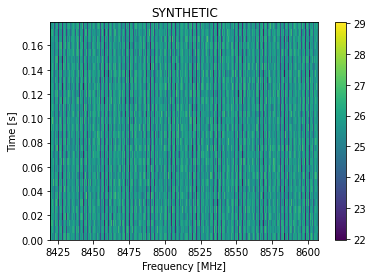

In [10]:
fr = stg.Frame('essai_voya.rawspec.0000.fil')
print(fr.shape)
fr.bl_plot()